Objetivo:
Esse notebook tem como objetivo facilitar a visualização das informações geradas com os dados antes da limpeza e a visualização dos gráficos de análise exploratória gerados após a limpeza dos dados

Metadados:

'events.csv' - dados de comportamento dos usuários
 - timestamp: momento em que o evento foi realizado (Unix time)
 - visitorid: ID único para cada visitante do site
 - event: ação realizada pelo visitante, pode ser 'view', 'addtocart' e 'transanction'
 - itemid: ID único para cada item a venda no e-commerce
 - transactionid: ID único gerado quando o a ação realizada for 'transaction'

'items_properties_part*.csv' -  propriedade dos itens (histórico temporal)
- timestamp: quando a propriedade foi registrada
- itemid: ID do item
- property: tipo de propriedade (nome codificado)
- value: valor da propriedade (codificado ou numérico com prefixo 'n')

'category_tree.csv' -  hierarquia de categorias
- categoryid: ID da categoria filha
- parentid: ID da categoria mãe (pode estar ausente se for a raiz)

In [22]:
##-----------Bibliotecas necessárias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib.ticker import FuncFormatter

In [23]:
##-----------Load e Extraction
df_events = pd.read_csv(r'events.csv')
df_item_props_part1 = pd.read_csv(r'item_properties_part1.csv')
df_item_props_part2 = pd.read_csv(r'item_properties_part2.csv')
df_category = pd.read_csv(r'category_tree.csv')

In [24]:
#Interações por usuário e produto
##Interações por usuário
user_interactions = df_events['visitorid'].value_counts()
print('\nEventos por cada usuário', '\n',user_interactions.head())

##Interações por item
item_interactions = df_events['itemid'].value_counts()
print('\nEventos com cada item:', '\n',item_interactions.head())

##Interações agrupadas por tipo de evento
#usuario
user_event_counts = df_events.groupby(['visitorid', 'event']).size().unstack(fill_value=0)
print('\nInterações de cada usuário por tipo de evento:')
print(user_event_counts.head())
#item
item_event_counts = df_events.groupby(['itemid', 'event']).size().unstack(fill_value=0)
print('\nInterações de cada item por tipo de evento:')
print(item_event_counts.head())


# Antes de qualquer limpeza, foi feito uma análise para entender o a relação dos dados, como os eventos estavam distribuídos entre os usuários e os produtos, 
# e também como os eventos estavam distribuídos entre os tipos de eventos.


Eventos por cada usuário 
 visitorid
1150086    7757
530559     4328
152963     3024
895999     2474
163561     2410
Name: count, dtype: int64

Eventos com cada item: 
 itemid
187946    3412
461686    2978
5411      2334
370653    1854
219512    1800
Name: count, dtype: int64

Interações de cada usuário por tipo de evento:
event      addtocart  transaction  view
visitorid                              
0                  0            0     3
1                  0            0     1
2                  0            0     8
3                  0            0     1
4                  0            0     1

Interações de cada item por tipo de evento:
event   addtocart  transaction  view
itemid                              
3               0            0     2
4               0            0     3
6               0            0    29
9               0            0     2
15              3            1    18


In [25]:
##Produtos sem eventos
products_event = set(df_events['itemid'].unique())

products_prop1 = set(df_item_props_part1['itemid'].unique()) 
products_prop2 = set(df_item_props_part2['itemid'].unique())
products_catalog = products_prop1.union(products_prop2)

products_only_props = products_catalog - products_event
print('\nProdutos com propriedas mas sem eventos:', len(products_only_props))

products_only_events = products_event - products_catalog
print('\nProdutos apenas com eventos:', len(products_only_events))

# Análise feita pra entender a quantidade de produtos que poderiam ser considerados inativos, ou seja, não tiveram eventos registrados
# Além disso, foi verificado a quantidade de produtos que tinham eventos registrados, mas não constavam em nenhum dos arquivos de propriedades.	


Produtos com propriedas mas sem eventos: 231807

Produtos apenas com eventos: 49815


In [26]:
##-----------Data Cleaning
#Remover produtos com poucos registros e remover produtos que estao em eventos mas nao estão catalogados
df_events = df_events[~df_events['itemid'].isin(products_only_events)]

df_item_props_part1 = df_item_props_part1[~df_item_props_part1['itemid'].isin(products_only_props)]
df_item_props_part2 = df_item_props_part2[~df_item_props_part2['itemid'].isin(products_only_props)]

#Filtrar os usuários com base em um limite minimo de interações
user_interactions = df_events['visitorid'].value_counts()
interactions_limit = 5
active_visitors = user_interactions[user_interactions>=interactions_limit].index
df_events = df_events[df_events['visitorid'].isin(active_visitors)]

#Converter timestamp para datetime
df_events['timestamp'] = pd.to_datetime(df_events['timestamp'], unit = 'ms')
print('\n',df_events['timestamp'].head()) #garantir que a conversão foi feita corretamente



#Colunas auxiliares
##1. numero de item comprados
itens_purchased = df_events[df_events['event'] == 'transaction'].groupby('visitorid')['itemid'].count()
df_events['n_itens_purchased'] = None
mask1 = df_events['event'] == 'transaction'
df_events.loc[mask1, 'n_itens_purchased'] = df_events.loc[mask1, 'visitorid'].map(itens_purchased)

##2. data da ultima compra
last_purchase = df_events[df_events['event'] == 'transaction'].groupby('visitorid')['timestamp'].max()
df_events['last_purchase'] = pd.NaT
mask = df_events['event'] == 'transaction'
df_events.loc[mask, 'last_purchase'] = df_events.loc[mask, 'visitorid'].map(last_purchase)


 1    2015-06-02 05:50:14.164
8    2015-06-02 04:54:59.221
15   2015-06-02 05:22:11.378
20   2015-06-02 05:47:50.841
24   2015-06-02 05:33:23.944
Name: timestamp, dtype: datetime64[ns]


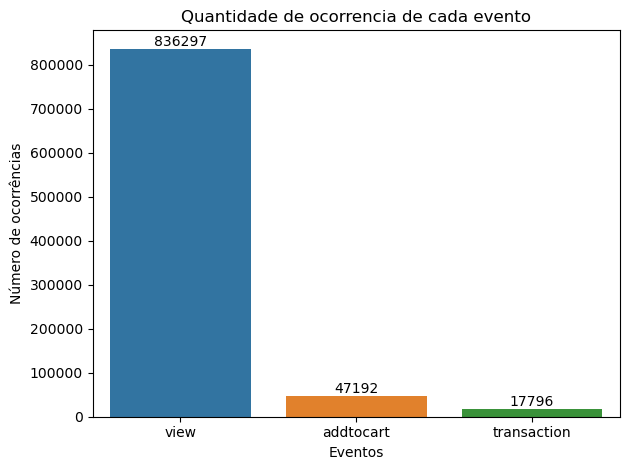

In [27]:
##-----------Data analysis
#1.Gráficos
#### número de eventos por tipo
n_events = sns.countplot(df_events, x= 'event', hue='event' )
for container in n_events.containers:
    n_events.bar_label(container) 
plt.title('Quantidade de ocorrencia de cada evento')
plt.xlabel('Eventos')
plt.ylabel('Número de ocorrências')
plt.tight_layout()
plt.show()

# O gráfico mostra que a maioria dos eventos são visualizações dos itens, em seguida, há adições ao carrinho e, por último, as transações.
# Esses dados são comuns em e-commerce, mas indicam que os dados são desbalanceados, ou seja, para a recomendação terá que ter um peso consideravelmente diferente para cada ação.
# Além disso, pode indicar que a maioria dos usuários está apenas navegando pelos produtos, com uma taxa de conversão relativamente baixa.

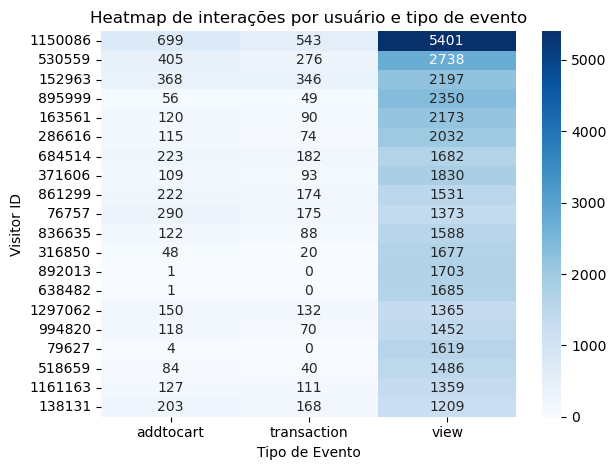

In [28]:
#### heatmap de cada interação
user_event_matrix = pd.crosstab(df_events['visitorid'], df_events['event'])
first_20_users = df_events['visitorid'].value_counts().head(20).index
user_event_matrix = user_event_matrix.loc[first_20_users]
sns.heatmap(user_event_matrix, annot=True, cmap= 'Blues', fmt='d')
plt.title('Heatmap de interações por usuário e tipo de evento')
plt.ylabel('Visitor ID')
plt.xlabel('Tipo de Evento')
plt.tight_layout()
plt.show()


# O heatmap mostra a quantidade de cada tipo de evento por usuário, foi levando em conta os usuários com a maior soma de eventos.
# É perceptível que a maioria dos usuários que tem uma grande número de visualizações, também apresentam um número maior de transações, havendo poucas exceções.

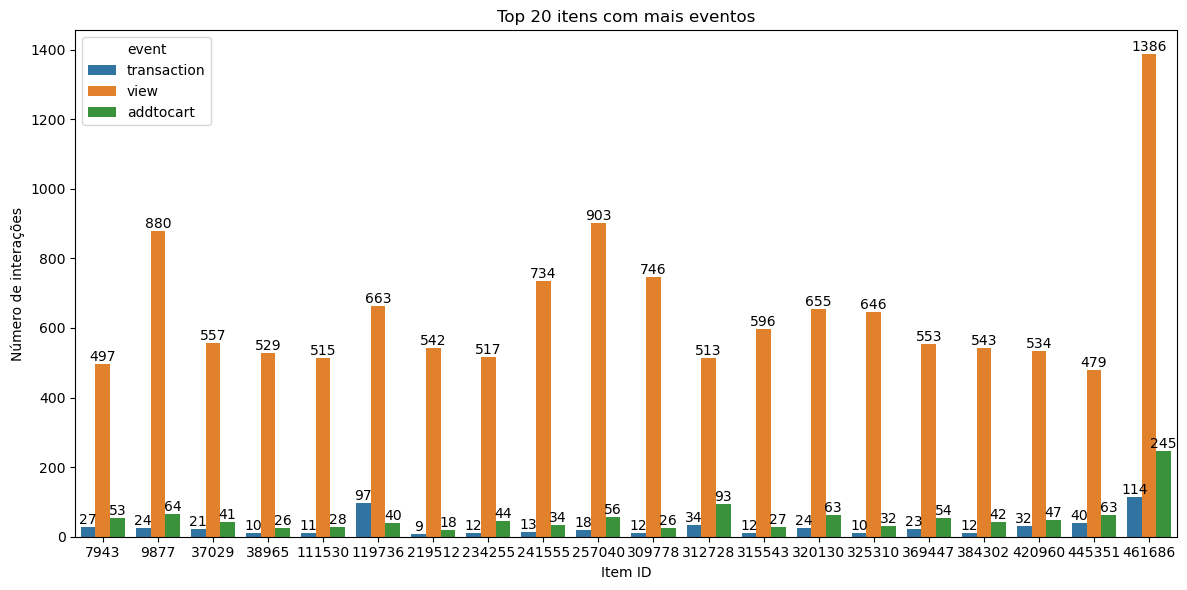

In [29]:
#### produtos com mais interações
item_interactions = df_events['itemid'].value_counts() #Refiltrar após o data cleaning
top_itens = item_interactions.head(20).index
top_item_interactions = df_events[df_events['itemid'].isin(top_itens)]

plt.figure(figsize=(12, 6))
most_viewed = sns.countplot(top_item_interactions, x= 'itemid', hue='event')
for container in most_viewed.containers:
    most_viewed.bar_label(container)
plt.title('Top 20 itens com mais eventos')
plt.xlabel('Item ID')
plt.ylabel('Número de interações')
plt.tight_layout()
plt.show()


# O gráfico mostra que os produtos com mais eventos são aqueles que possuem mais visualizações, seguidos por adições ao carrinho e, por último, as transações.
# É possível perceber como a distribuição dos eventos é realmente desbalanceada, sendo o item '461686' com mais interações (1745 no total), tendo apenas 114 transações.


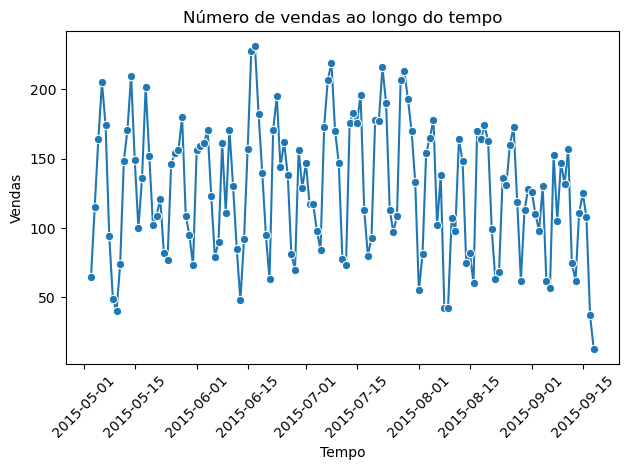

In [30]:
#### comparação de tempo e número de vendas
df_transactions = df_events[df_events['event'] == 'transaction'].copy()
df_transactions.loc[:, 'date'] = df_transactions['timestamp'].dt.date
daily_counts = df_transactions.groupby('date').size().reset_index(name= 'num_transactions')

sns.lineplot(data= daily_counts, x= 'date', y = 'num_transactions', marker = 'o')
plt.title('Número de vendas ao longo do tempo')
plt.xlabel('Tempo')
plt.ylabel('Vendas')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()


# A comparação é feita entre o número de vendas e o tempo (em dias) durante cinco meses, de maio a agosto de 2015.
# Considerando que dataset do e-commerce é de fora do Brasil, datas importantes para o comércio brasileieiro, como o dia dos namoraods (12 de junho) não tem impacto significativo nas vendas. 
# Dessa forma, pode-se considerar datas como o dia das mães (11 de maio), que foi perceptível um pico nas vendas nos dias anteriores,
# com aproximadamente 200 vendas no dia 6 de maio.
# No entanto, o maior número de vendas ocorreu no dai 16 de junho, com cerca de 230 vendas e o maior declínio se apresentou no dia 18 de setembro, cerca de 13 vendas. 


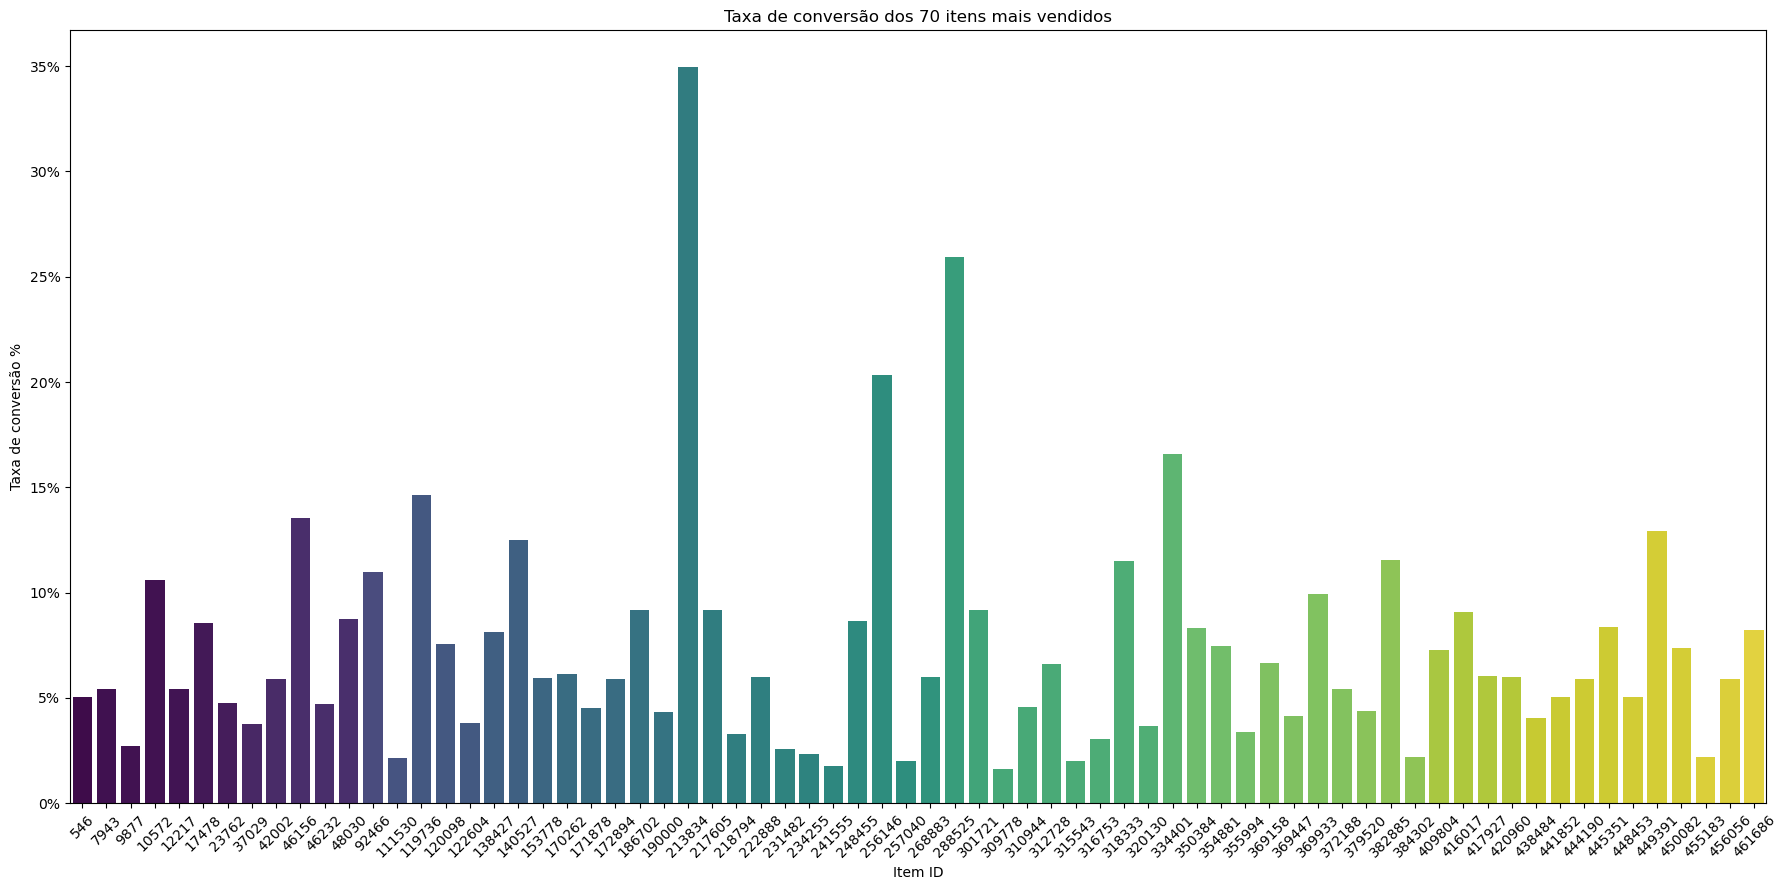

In [31]:
#### taxa de conversão por produto
view_df = df_events[df_events['event'] == 'view']
transaction_df = df_events[df_events['event'] == 'transaction']

top_itens = transaction_df['itemid'].value_counts().head(70).index

views_df_top = view_df[view_df['itemid'].isin(top_itens)]
transactions_df_top = transaction_df[transaction_df['itemid'].isin(top_itens)]

view_counts = views_df_top.groupby('itemid').size()
transaction_counts = transactions_df_top.groupby('itemid').size()

conversion_rate = (transaction_counts/view_counts).dropna()*100

conversion_df = conversion_rate.reset_index()
conversion_df.columns= ['itemid', 'conversion_rate']

plt.figure(figsize=(18, 9))
conversion_graph = sns.barplot(conversion_df, x= 'itemid', y='conversion_rate', palette='viridis', hue= 'itemid', legend= False)
plt.title('Taxa de conversão dos 70 itens mais vendidos')
plt.ylabel('Taxa de conversão %')
plt.xlabel('Item ID')
plt.xticks(rotation= 45)
formatter = FuncFormatter(lambda y, _: f'{y:.0f}%')
conversion_graph.yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()


# A taxa de conversão é a porcentagem de visualizações que resultaram em uma transação.
# Nesse gráfico foram observadas as taxas de conversão dos 70 itens mais vendidos.
# Dos quais, a maior taxa de conversão foi de 35% do item ‘21384’, que não aparece no gráfico de itens com mais eventos.
# Provavelmente porque a soma dos eventos nesse item não está entre os maiores, ou seja, apesar de ter menos eventos, 35% das visualizações resultaram em vendas.
